#### Capstone Project - Final Submission

# THE FUTURE OF FOOD SHOPPING

*Insights from the Instacart Online Grocery Shopping Dataset 2017*

### 1. Overview

Even though all the other notebooks from this project were written in Pyspark or Python the final submission was written in R, due to computational resource issues in the parameter tuning of Xgboost.
Here we will focus on the Feature Engineering, Tuning the Parameters and Model Evaluation.

In [4]:
# Import the necessaries libraries for the code
library(data.table)
library(dplyr)
library(tidyr)

# Load Data
path <- "D:/DADOS USUARIO/Documents/springboard/capstone project/Instacart Kaggle"

aisles <- fread(file.path(path, "aisles.csv"))
departments <- fread(file.path(path, "departments.csv"))
orderp <- fread(file.path(path, "order_products__prior.csv"))
ordert <- fread(file.path(path, "order_products__train.csv"))
orders <- fread(file.path(path, "orders.csv"))
products <- fread(file.path(path, "products.csv"))

# Reshape data 
aisles$aisle <- as.factor(aisles$aisle)
departments$department <- as.factor(departments$department)
orders$eval_set <- as.factor(orders$eval_set)
products$product_name <- as.factor(products$product_name)

products <- products %>% 
  inner_join(aisles) %>% inner_join(departments) %>% 
  select(-aisle_id, -department_id)
rm(aisles, departments)

ordert$user_id <- orders$user_id[match(ordert$order_id, orders$order_id)]

orders_products <- orders %>% inner_join(orderp, by = "order_id")

rm(orderp)
gc()

Read 32434489 rows and 4 (of 4) columns from 0.538 GB file in 00:00:04


Joining, by = "aisle_id"
Joining, by = "department_id"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,615044,32.9,6336089,338.4,20885653,1115.5
Vcells,436507209,3330.3,683370284,5213.8,679998362,5188.0


### 2. Feature Engineering

This step is fundamental to the application of machine learning, and is a reason of struggle for a lot data scientists as it is a mix of domain knowledge and art. A good definition is the process of transforming data to create model inputs.
For this project we have created 3 types of features:

1. **Products**: *What this product is like?*
2. **Users**: *What this user is like?*
3. **Products-Users**: *What is the user relation with the product?*


In [5]:
## Products 
prd <- orders_products %>%
  arrange(user_id, order_number, product_id) %>%
  group_by(user_id, product_id) %>%
  mutate(product_time = row_number()) %>%
  ungroup() %>%
  group_by(product_id) %>%
  summarise(
    prod_orders = n(),
    prod_reorders = sum(reordered),
    prod_first_orders = sum(product_time == 1),
    prod_second_orders = sum(product_time == 2)
  )

prd$prod_reorder_probability <- prd$prod_second_orders / prd$prod_first_orders
prd$prod_reorder_times <- 1 + prd$prod_reorders / prd$prod_first_orders
prd$prod_reorder_ratio <- prd$prod_reorders / prd$prod_orders

prd <- prd %>% select(-prod_reorders, -prod_first_orders, -prod_second_orders)

rm(products)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,564772,30.2,15453322,825.3,20885653,1115.5
Vcells,436242851,3328.3,984229208,7509.1,715479663,5458.7


#### 2.1 Products

* **times_prod_ordered**: number the products ordered.
* **prod_reorder_probability**: probability of the product being reordered. Ex. every reorder(bought a second time) of bananas divided by every first order of bananas.
* **prod_reorder_times**: how many times the product was reordered
* **prod_reorder_ratio**: ratio of a product reorders. Ex. times bananas were reordered divided by the times bananas were ordered.


In [6]:
## Users 
users <- orders %>%
  filter(eval_set == "prior") %>%
  group_by(user_id) %>%
  summarise(
    user_orders = max(order_number),
    user_period = sum(days_since_prior_order, na.rm = T),
    user_mean_days_since_prior = mean(days_since_prior_order, na.rm = T)
  )

us <- orders_products %>%
  group_by(user_id) %>%
  summarise(
    user_total_products = n(),
    user_reorder_ratio = sum(reordered == 1) / sum(order_number > 1),
    user_distinct_products = n_distinct(product_id)
  )

users <- users %>% inner_join(us)
users$user_average_basket <- users$user_total_products / users$user_orders

us <- orders %>%
  filter(eval_set != "prior") %>%
  select(user_id, order_id, eval_set,
         time_since_last_order = days_since_prior_order)

users <- users %>% inner_join(us)

rm(us)
gc()

Joining, by = "user_id"
Joining, by = "user_id"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,564864,30.2,12362657,660.3,20885653,1115.5
Vcells,437995949,3341.7,984229208,7509.1,715479663,5458.7


#### 2.2 Users

* **user_mean_days_since_prior**: the average number of days that the user orders
* **user_orders**: number of orders made by the user
* **user_period**: number of days that a user made the first order
* **user_total_prod**: number of products bought by the user
* **user_reorder_ratio**: ratio of reorders made by the user.
* **distinct**: number of distinct products ordered by the user
* **user_average_basket**: the average number of products in a order


In [7]:
# Products-Users
data <- orders_products %>%
  group_by(user_id, product_id) %>% 
  summarise(
    up_orders = n(),
    up_first_order = min(order_number),
    up_last_order = max(order_number),
    up_average_cart_position = mean(add_to_cart_order))

rm(orders_products, orders)

data <- data %>% 
  inner_join(prd, by = "product_id") %>%
  inner_join(users, by = "user_id")

data$up_order_rate <- data$up_orders / data$user_orders
data$up_orders_since_last_order <- data$user_orders - data$up_last_order
data$up_order_rate_since_first_order <- data$up_orders / (data$user_orders - data$up_first_order + 1)

data <- data %>% 
  left_join(ordert %>% select(user_id, product_id, reordered), 
            by = c("user_id", "product_id"))

rm(ordert, prd, users)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,564763,30.2,11449744,611.5,20885653,1115.5
Vcells,500011772,3814.8,1181155049,9011.5,980362119,7479.6


#### 2.3 Products-Users

* **user_mean_days_since_prior**: the average number of days that the user orders
* **user_orders**: number of orders made by the user
* **user_period**: number of days that a user made the first order
* **user_total_prod**: number of products bought by the user
* **user_reorder_ratio**: ratio of reorders made by the user.
* **distinct**: number of distinct products ordered by the user
* **user_average_basket**: the average number of products in a order


### 3. Tuning the Parameters

XGBoost is a powerful tool, the difficult part is in improving the model, because this algorithm uses multiple parameters. To improve the model, parameter tuning is necessary. 

For tuning the parameters I followed AARSHAY JAIN´s great tutorial steps [https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/].


**Step 1:**

Fix learning rate and number of estimators for tuning tree-based parameters

max_depth = 6 : This should be between 3-10

min_child_weight = 1 : A smaller value is chosen 

gamma = 0 : A smaller value can be chosen for starting

subsample, colsample_bytree = 1 : Typical values range between 0.5-0.9

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,565539,30.3,9159795,489.2,20885653,1115.5
Vcells,240509883,1835.0,944924039,7209.2,1179195249,8996.6


Warning message:
"package 'caret' was built under R version 3.4.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.4.3"Warning message:
"package 'xgboost' was built under R version 3.4.3"
Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice



[13:03:26] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:03:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:03:35] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:03:39] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:03:43] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[1]	train-error:0.092236+0.000059	test-error:0.092279+0.000487 
[11]	train-error:0.090572+0.000094	test-error:0.090637+0.000428 
[21]	train-

Confusion Matrix and Statistics

          Reference
Prediction       0       1
         0 2075431  115951
         1  218014  133002
                                          
               Accuracy : 0.8686          
                 95% CI : (0.8682, 0.8691)
    No Information Rate : 0.9021          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3713          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9049          
            Specificity : 0.5342          
         Pos Pred Value : 0.9471          
         Neg Pred Value : 0.3789          
             Prevalence : 0.9021          
         Detection Rate : 0.8163          
   Detection Prevalence : 0.8619          
      Balanced Accuracy : 0.7196          
                                          
       'Positive' Class : 0               
                                          

Warning message:
"Setting row names on a tibble is deprecated."

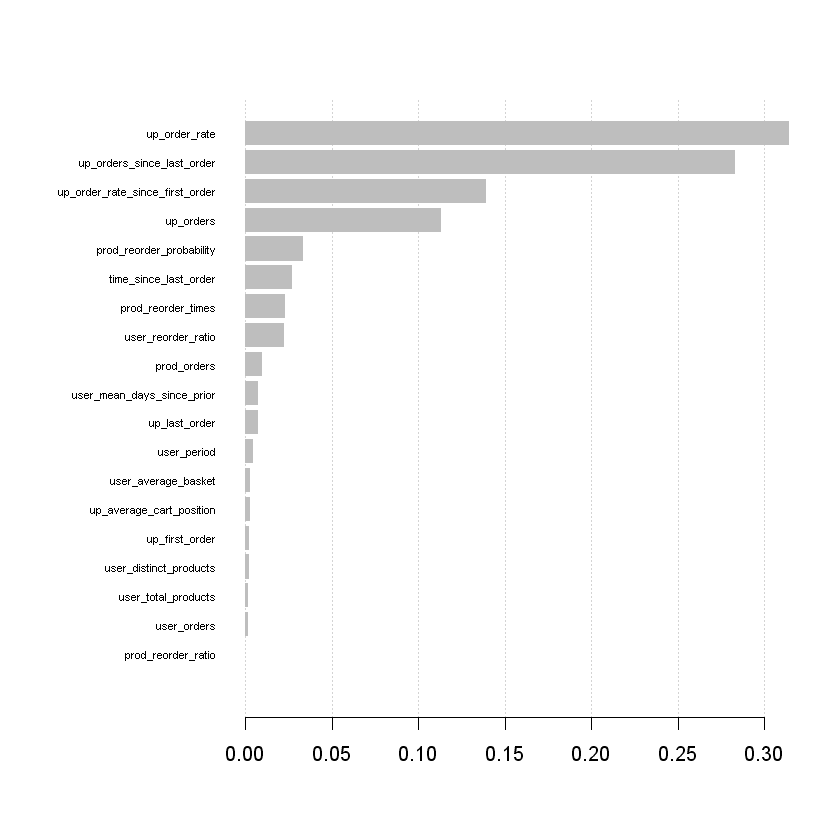

In [8]:
# Train / Test datasets 
train <- as.data.frame(data[data$eval_set == "train",])
train$eval_set <- NULL
train$user_id <- NULL
train$product_id <- NULL
train$order_id <- NULL
train$reordered[is.na(train$reordered)] <- 0

test <- as.data.frame(data[data$eval_set == "test",])
test$eval_set <- NULL
test$user_id <- NULL
test$reordered <- NULL

rm(data)
gc()
#splitting data using Caret package
library(caret)
trainIndex <- createDataPartition(train$reordered, p=0.7, list=FALSE, times=1)
xgb_train <- train[trainIndex,]
xgb_test <- train[-trainIndex,]

# Model using default parameters
library(xgboost)

labels <- xgb_train$reordered
ts_label <- xgb_test$reordered

#drop a column
mtx_train <- model.matrix(~.+0,data = xgb_train[,-20]) 
mtx_test <- model.matrix(~.+0,data = xgb_test[,-20])


#preparing matrix 
dtrain <- xgb.DMatrix(data = mtx_train,label = labels) 
dtest <- xgb.DMatrix(data = mtx_test,label=ts_label)

params <- list(
  booster = "gbtree", 
  objective = "binary:logistic",
  eta=0.3, 
  gamma=0, 
  max_depth=6, 
  min_child_weight=1, 
  subsample=1, 
  colsample_bytree=1
  )

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 100, nfold = 5, showsd = T, stratified = T, print_every_n = 10, early_stop_rounds = 20, maximize = F)
#after 100 iterations no conversion last test-error:0.089773

#first default - model training
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 100, watchlist = list(val=dtest,train=dtrain), print_every_n = 10, early_stop_round = 10, maximize = F , eval_metric = "error")
#model prediction
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.2,1,0)


#confusion matrix
library(caret)
confusionMatrix(xgbpred, ts_label)
#Accuracy - 86.82%` 

#view variable importance plot
mat <- xgb.importance (feature_names = colnames(mtx_train),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20])


# Apply model 
dtest <- xgb.DMatrix(as.matrix(test %>% select(-order_id, -product_id)))
test$reordered <- predict(xgb1, dtest)

test$reordered <- (test$reordered > 0.2) * 1

submission <- test %>%
  filter(reordered == 1) %>%
  group_by(order_id) %>%
  summarise(
    products = paste(product_id, collapse = " ")
  )

missing <- data.frame(
  order_id = unique(test$order_id[!test$order_id %in% submission$order_id]),
  products = "None"
)
missing$products <- as.character(missing$products)
submission <- submission %>% bind_rows(missing) %>% arrange(order_id)
rownames(submission) <- submission$order_id
write.csv(submission, file = "sub_def.csv", row.names = FALSE, quote = FALSE)

<div class="alert alert-block alert-success">
<font color=green>

Result: F1 Score of 0.3794 and position Kaggle Ranking Position 1087

</div>

**Step 2:**

As test-error did not reach convergence. We increased the number of estimators to 300 and re-run the command to get the number of optimal estimators

In [9]:
xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 300, nfold = 5, showsd = T, stratified = T, print_every_n = 10, early_stop_rounds = 20, maximize = F)
#after 300 iterations no conversion last test-error:0.089488

#300 iterations - model training
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 300, watchlist = list(val=dtest,train=dtrain), print_every_n = 10, early_stop_round = 10, maximize = F , eval_metric = "error")
#model prediction
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.2,1,0)


#confusion matrix
library(caret)
confusionMatrix(xgbpred, ts_label)
#Accuracy - 86.86%` 

#view variable importance plot
mat <- xgb.importance (feature_names = colnames(mtx_train),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20])


# Apply model 
dtest <- xgb.DMatrix(as.matrix(test %>% select(-order_id, -product_id)))
test$reordered <- predict(xgb1, dtest)

test$reordered <- (test$reordered > 0.2) * 1

submission <- test %>%
  filter(reordered == 1) %>%
  group_by(order_id) %>%
  summarise(
    products = paste(product_id, collapse = " ")
  )

missing <- data.frame(
  order_id = unique(test$order_id[!test$order_id %in% submission$order_id]),
  products = "None"
)
missing$products <- as.character(missing$products)
submission <- submission %>% bind_rows(missing) %>% arrange(order_id)
rownames(submission) <- submission$order_id
write.csv(submission, file = "sub_def300.csv", row.names = FALSE, quote = FALSE)

[13:30:39] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:30:43] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:30:47] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:30:52] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:30:56] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[1]	train-error:0.092207+0.000160	test-error:0.092282+0.000296 
[11]	train-error:0.090597+0.000098	test-error:0.090685+0.000317 
[21]	train-

ERROR: Error in xgb.iter.eval(bst$handle, watchlist, iteration - 1, feval): [14:09:02] amalgamation/../src/metric/elementwise_metric.cc:27: Check failed: (info.labels.size()) != (0) label set cannot be empty


<div class="alert alert-block alert-success">
<font color=green>

Result: F1 Score of 0.3805265 and Kaggle Ranking Position 825

</div>

**Step 3:**

Test-error did not reach convergence, but we will continue to the next step. Which is to use gridsearch to tune max_depth and min_child_weight as tune these first will have the highest impact on model outcome. 

max_depth = [7,8]

min_child_weight = [1,2,3]

In [10]:
searchGridSubCol <- expand.grid(subsample = c(0.1), 
                                colsample_bytree = c(1),
                                max_depth = c(7,8),
                                min_child = seq(1,3), 
                                eta = c(0.3)
)

ntrees <- 5

system.time(
  rmseErrorsHyperparameters <- apply(searchGridSubCol, 1, function(parameterList){
    
    #Extract Parameters to test
    currentSubsampleRate <- parameterList[["subsample"]]
    currentColsampleRate <- parameterList[["colsample_bytree"]]
    currentDepth <- parameterList[["max_depth"]]
    currentEta <- parameterList[["eta"]]
    currentMinChild <- parameterList[["min_child"]]
    xgboostModelCV <- xgb.cv(data =  dtrain, nrounds = ntrees, nfold = 2, showsd = TRUE, 
                             metrics = "rmse", verbose = TRUE, "eval_metric" = "rmse",
                             "objective" = "binary:logistic", "max.depth" = currentDepth, "eta" = currentEta,                               
                             "subsample" = currentSubsampleRate, "colsample_bytree" = currentColsampleRate
                             , print_every_n = 10, "min_child_weight" = currentMinChild, booster = "gbtree",
                             early_stopping_rounds = 10)
    
    xvalidationScores <- as.data.frame(xgboostModelCV$evaluation_log)
    rmse <- tail(xvalidationScores$test_rmse_mean, 1)
    trmse <- tail(xvalidationScores$train_rmse_mean,1)
    output <- return(c(rmse, trmse, currentSubsampleRate, currentColsampleRate, currentDepth, currentEta, currentMinChild))
    
  }))

output <- as.data.frame(t(rmseErrorsHyperparameters))
head(output)
varnames <- c("TestRMSE", "TrainRMSE", "SubSampRate", "ColSampRate", "Depth", "eta", "currentMinChild")
names(output) <- varnames


[1]	train-rmse:0.401068+0.000012	test-rmse:0.401112+0.000026 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[5]	train-rmse:0.279195+0.000093	test-rmse:0.279420+0.000057 
[1]	train-rmse:0.401103+0.000172	test-rmse:0.401187+0.000105 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[5]	train-rmse:0.278879+0.000166	test-rmse:0.279259+0.000163 
[1]	train-rmse:0.401085+0.000054	test-rmse:0.401123+0.000028 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[5]	train-rmse:0.279200+0.000185	test-rmse:0.279416+0.000039 
[1]	train-rmse:0.401087+0.000004	test-rmse:0.401158+0.000045 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[5]	train-rmse:0.278897+0.000104	test-

   user  system elapsed 
1649.74   31.79  297.48 

V1,V2,V3,V4,V5,V6,V7
0.2794200,0.2791950,0.1,1,7,0.3,1
0.2792595,0.2788790,0.1,1,8,0.3,1
0.2794160,0.2792005,0.1,1,7,0.3,2
0.2792720,0.2788970,0.1,1,8,0.3,2
0.2793870,0.2791735,0.1,1,7,0.3,3
0.2792885,0.2789205,0.1,1,8,0.3,3


In [11]:
# tunning  max_depth = 8 and min_child = 1 as found in the gridseach

params <- list(
  booster = "gbtree", 
  objective = "binary:logistic",
  eta=0.3, 
  gamma=0, 
  max_depth=8, 
  min_child_weight=1, 
  subsample=1, 
  colsample_bytree=1
)


#300 iterations & tunning - model training
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 300, watchlist = list(val=dtest,train=dtrain), print_every_n = 10, early_stop_round = 10, maximize = F , eval_metric = "error")
#model prediction
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.2,1,0)


#confusion matrix
library(caret)
confusionMatrix(xgbpred, ts_label)
#Accuracy - 86.93%` 

#view variable importance plot
mat <- xgb.importance (feature_names = colnames(mtx_train),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20])


# Apply model 
dtest <- xgb.DMatrix(as.matrix(test %>% select(-order_id, -product_id)))
test$reordered <- predict(xgb1, dtest)

test$reordered <- (test$reordered > 0.2) * 1

submission <- test %>%
  filter(reordered == 1) %>%
  group_by(order_id) %>%
  summarise(
    products = paste(product_id, collapse = " ")
  )

missing <- data.frame(
  order_id = unique(test$order_id[!test$order_id %in% submission$order_id]),
  products = "None"
)
missing$products <- as.character(missing$products)
submission <- submission %>% bind_rows(missing) %>% arrange(order_id)
rownames(submission) <- submission$order_id
write.csv(submission, file = "sub_def300tun.csv", row.names = FALSE, quote = FALSE)

ERROR: Error in xgb.iter.eval(bst$handle, watchlist, iteration - 1, feval): [15:23:56] amalgamation/../src/metric/elementwise_metric.cc:27: Check failed: (info.labels.size()) != (0) label set cannot be empty


<div class="alert alert-block alert-success">
<font color=green>

Result: F1 Score of 0.3764418 and Kaggle Ranking Position 1618

</div>